# Re-creation of the market making figures on page 252 of "Algorithmic and High-Frequency Trading" By Cartea et. al.

## Note: These simulations are statistically exact. There is no SDE discretization error. Also, it would be easier in some ways to just step the simulation forward at each time step and draw the necessary random variables. However, Python/NumPy works a lot better if we use vectors. We need to use a bit of knowledge about Poisson processes to pull it off.

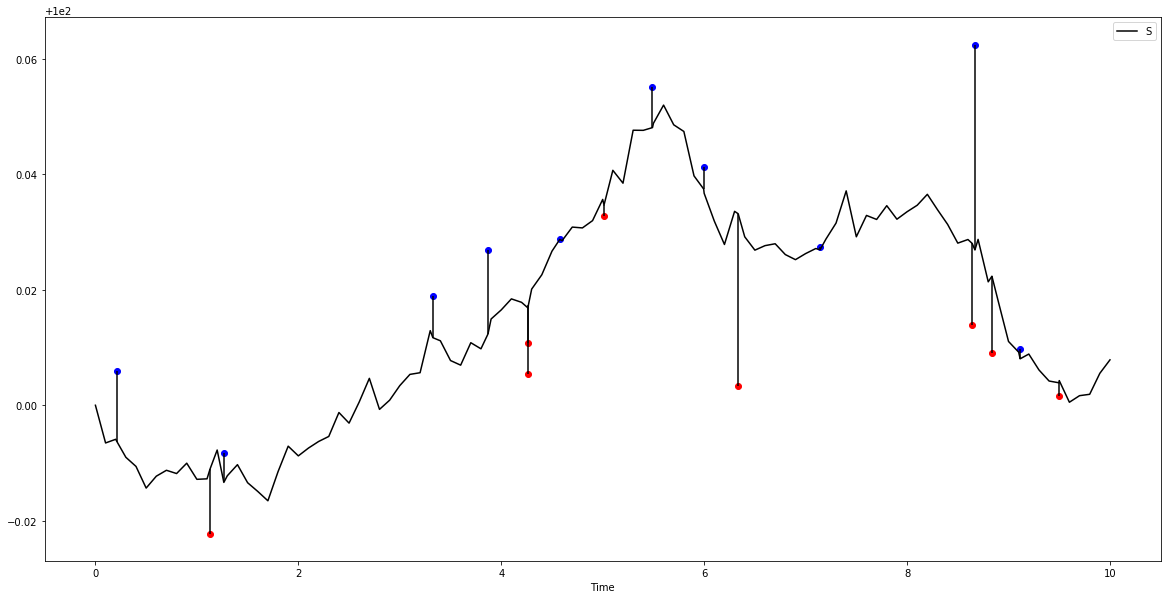

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

#set the parameters of the model
#if a variable is a pair, then the first and second elements are the minus/plus values, respectively
lmbda = (1., 1.)
kappa = 100.
q = (-10, 10)
phi = 2 * 10**(-4)
alpha = 10**(-4)
sigma = 0.01
S0 = 100.

#set the parameters of the simulations
T = 10.
time_steps = 100
times_subset = np.linspace(0, T, time_steps + 1)

#setup the matrix A (it isn't very big, so we won't bother with making it sparse)
q_vals = np.arange(q[0], q[1]+1)
squared_q_vals = np.square(q_vals)
A = np.diag(-phi * kappa * squared_q_vals) + np.diag(lmbda[0] * np.exp(-1) * np.ones(len(q_vals)-1), 1) + np.diag(lmbda[1] * np.exp(-1) * np.ones(len(q_vals)-1), -1)
z = np.exp(-alpha * kappa * squared_q_vals)

def get_paths():
    #if we add two independent Poisson processes,
    #we get another Poisson process whose intensity is the sum of the intensities
    number_of_market_orders = np.random.poisson(sum(lmbda) * T)
    market_orders_times = np.sort(T * np.random.uniform(size=number_of_market_orders))
    
    #now we can mark the Poisson process according to whether the order is a buy or sell
    #this marker is equal to 1 if it's a buy, 0 if it's a sell
    markers = np.random.binomial(n=1, p=lmbda[1] / sum(lmbda), size=number_of_market_orders)

    unsorted_times = np.append(times_subset, market_orders_times)
    sort_indices = np.argsort(unsorted_times)
    times = unsorted_times[sort_indices]
    
    dt = np.diff(times, prepend=[0.])
    scaled_normals = sigma * np.sqrt(dt) * np.random.normal(loc=0, scale=1, size=len(dt))
    S = S0 + np.cumsum(scaled_normals)
    S_at_MOs = S[sort_indices >= len(times_subset)]
    
    #now we can figure out how deep the MOs walk the LOB
    depths = -np.log(np.random.uniform(size=number_of_market_orders)) / kappa

    #TODO figure out where we posted the LOs and track the inventory
    
    return times, S, market_orders_times, markers, depths, S_at_MOs
    
times, S, market_orders_times, markers, depths, S_at_MOs = get_paths()
    
plt.rcParams["figure.figsize"] = (20,10)
    
plt.plot(times, S, c='black')

#plot the buy MOs
buy_times = np.extract(markers, market_orders_times)
buy_prices = np.extract(markers, S_at_MOs - depths)
plt.scatter(buy_times, buy_prices, c='red')
plt.vlines(buy_times, buy_prices, np.extract(markers, S_at_MOs))

#plot the sell MOs
sell_markers = np.logical_not(markers)
sell_times = np.extract(sell_markers, market_orders_times)
sell_prices = np.extract(sell_markers, S_at_MOs + depths)
plt.scatter(sell_times, sell_prices, c='blue')
plt.vlines(sell_times, np.extract(sell_markers, S_at_MOs), sell_prices)

plt.xlabel('Time')
plt.legend(['S'])

plt.show()
